# Import Library

In [19]:
import os
import cv2
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Flatten, Dropout, BatchNormalization, 
    Reshape, LSTM, Input, LeakyReLU
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNet
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau


In [20]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
INPUT_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = 3

# Image Processing

In [21]:
def image_preprocessing(image_path):
    # Baca gambar
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE))

    # Edge detection menggunakan kernel manual
    kernel_edge = np.array([[-1, -1, -1],
                            [-1,  8, -1],
                            [-1, -1, -1]])
    
    edges = cv2.filter2D(img, -1, kernel_edge)

    # Sharpening pada RGB
    kernel_sharpen = np.array([[0, -1, 0],
                            [-1,  5, -1],
                            [0, -1, 0]])
    sharpened = cv2.filter2D(img, -1, kernel_sharpen)
    
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(sharpened)
    axes[0].set_title('Sharpened (RGB)')
    axes[0].axis('off')
    
    axes[1].imshow(edges)
    axes[1].set_title('Edge Detection (RGB)')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Jalankan fungsi
# image_path = "dataset/valid/red_devil/Red-Devil-244_jpg.rf.a0570767ba2c29e2686282bc1d07d98d.jpg" 
# image_path = "new_data/WhatsApp Image 2022-11-05 at 22.42.11.jpg" 
# image_preprocessing(image_path)




## Membuat dataset generatornya dan mendefenisikan data Generatornya

### Augmentasi Data dan Normalisasi data

In [22]:
# Custom ImageDataGenerator dengan Preprocessing
class CustomImageDataGeneratorWithProcessing(ImageDataGenerator):
    def preprocessing_function(self, img_path):
        return image_preprocessing(img_path, target_size=IMG_SIZE)

In [23]:
# Data Generators
train_datagen = CustomImageDataGeneratorWithProcessing(
    rescale=1.0 / 255.0,
    zoom_range=0.7,
    brightness_range=[0.6, 1.4]
)

validation_datagen = CustomImageDataGeneratorWithProcessing(rescale=1.0 / 255.0)
test_datagen = CustomImageDataGeneratorWithProcessing(rescale=1.0 / 255.0)

## Mendefinisikan asal folder sumber file berasal

In [24]:
# Directories (Adjust paths as needed)
train_dir = 'dataset/train/'
val_dir = 'dataset/valid/'
test_dir = 'dataset/test/'

# Load Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Update NUM_CLASSES based on data
NUM_CLASSES = train_generator.num_classes
labels = train_generator.class_indices.keys()


Found 2721 images belonging to 3 classes.
Found 243 images belonging to 3 classes.
Found 99 images belonging to 3 classes.


In [25]:
labels

dict_keys(['mujahir', 'red_devil', 'sepat'])

# Visualisasi Data

Visualisasi data dengan train:


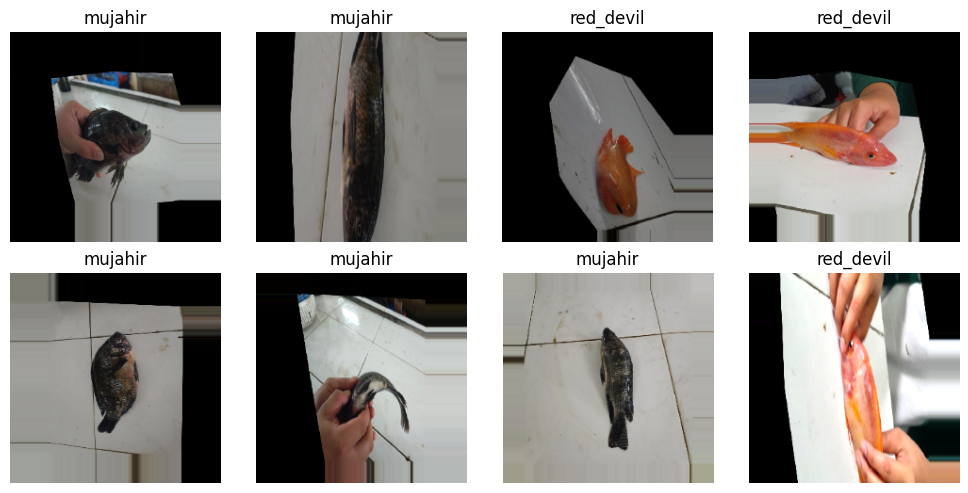

In [26]:
def plot_augmented_images(generator, labels, num_images=8):
    images, labels_batch = next(generator)

    num_images = min(num_images, len(images))  
    labels_decoded = [list(labels)[np.argmax(label)] for label in labels_batch[:num_images]]
    cols = 4  
    rows = (num_images + cols - 1) // cols  
    plt.figure(figsize=(cols * 2.5, rows * 2.5)) 

    for i in range(num_images):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.title(labels_decoded[i])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

print("Visualisasi data dengan train:")
plot_augmented_images(train_generator, labels)


### Grid Gambar dari Setiap Kelas

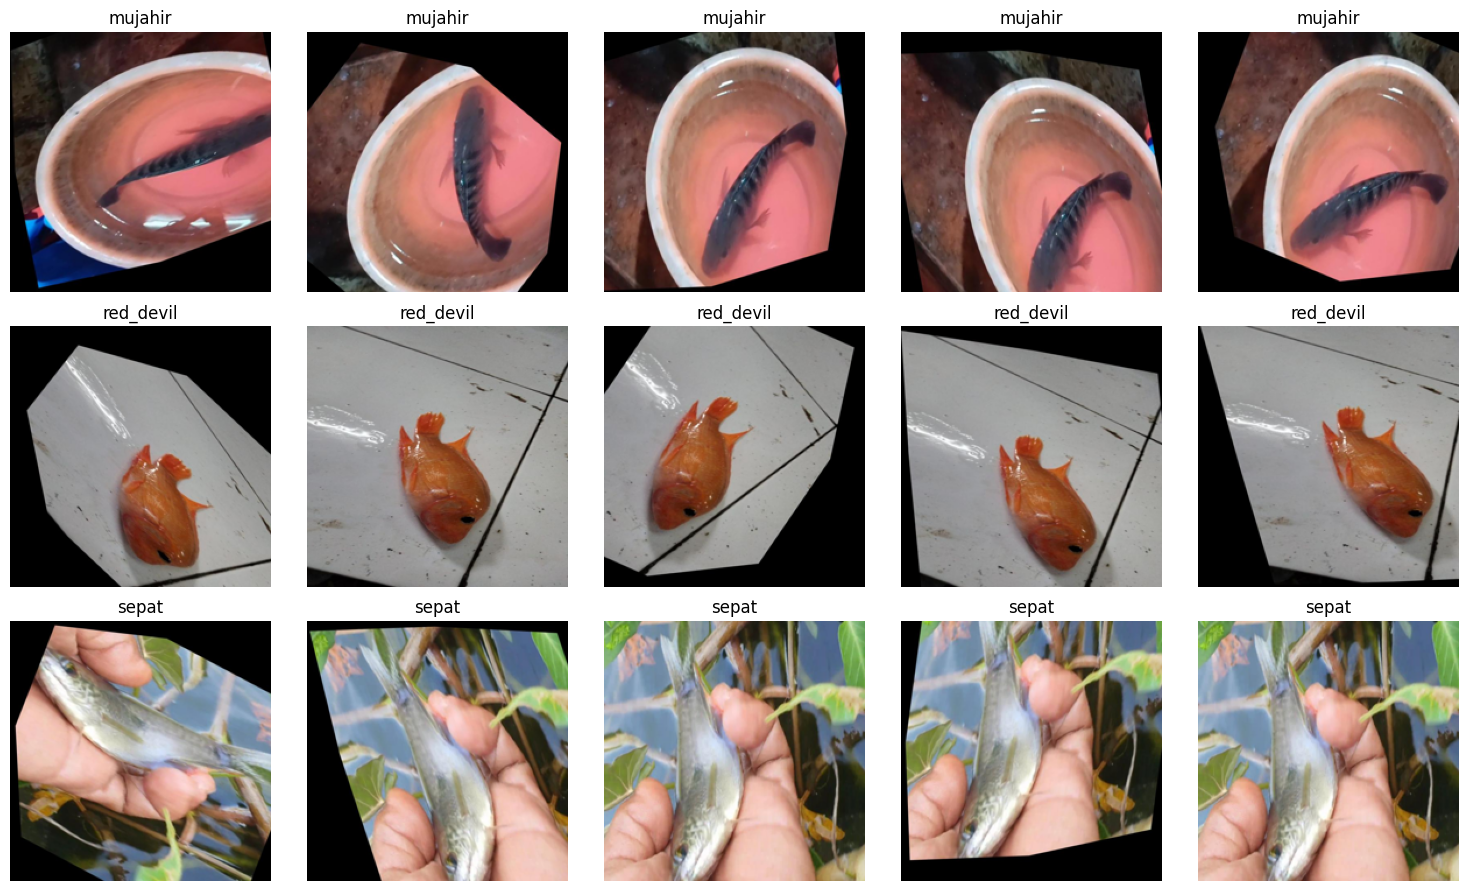

In [27]:
import os
from PIL import Image  
import matplotlib.pyplot as plt

def visualize_samples_per_class(directory, target_size, samples_per_class=5):
    classes = os.listdir(directory)
    plt.figure(figsize=(15, len(classes) * 3))
    
    for i, cls in enumerate(classes):
        class_path = os.path.join(directory, cls)
        images = os.listdir(class_path)[:samples_per_class]
        
        for j, img_file in enumerate(images):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).resize(target_size) 
            
            plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_samples_per_class(train_dir, target_size=IMG_SIZE, samples_per_class=5)


C:\Users\M S I\AppData\Local\Temp\ipykernel_89964\3841989112.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette="viridis")


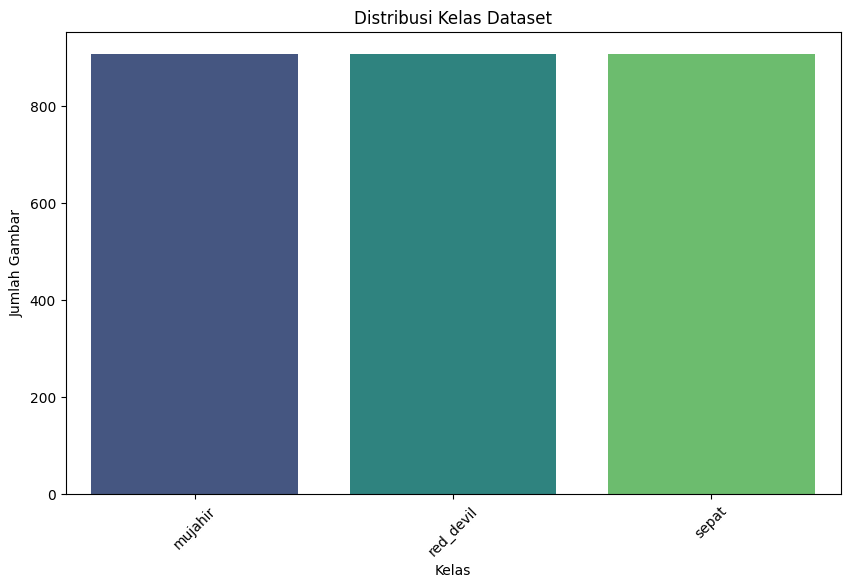

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 
import numpy as np

def plot_class_distribution(generator):
    """Visualisasi distribusi kelas"""
    class_counts = Counter(generator.classes) 
    class_names = list(generator.class_indices.keys())
    counts = [class_counts[i] for i in range(len(class_names))]  
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=counts, palette="viridis")
    plt.title("Distribusi Kelas Dataset")
    plt.ylabel("Jumlah Gambar")
    plt.xlabel("Kelas")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_generator)


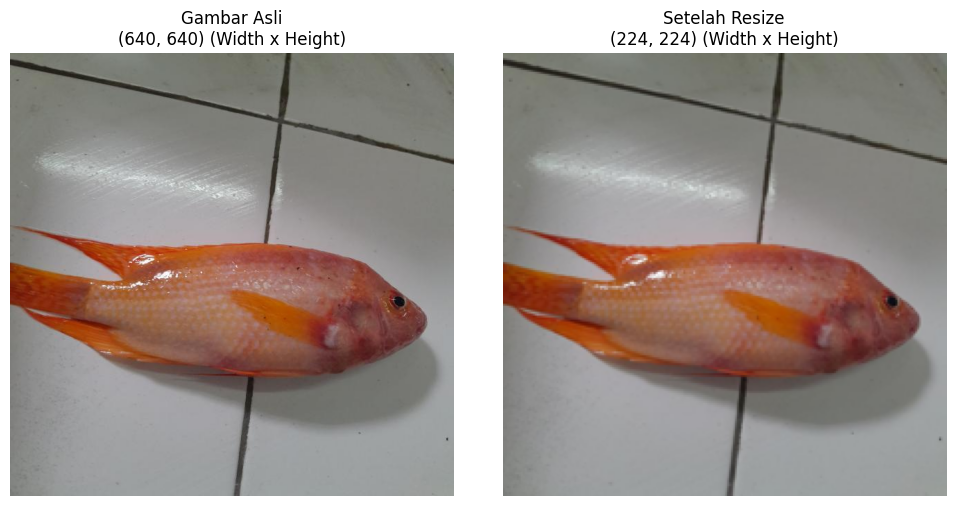

In [29]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def visualize_original_and_resized(image_path, target_size):
    try:

        img_original = Image.open(image_path)
        img_original_array = np.array(img_original)

        img_resized = img_original.resize(target_size)
        img_resized_array = np.array(img_resized)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(img_original_array)
        plt.title(f"Gambar Asli\n{img_original.size} (Width x Height)")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(img_resized_array)
        plt.title(f"Setelah Resize\n{target_size} (Width x Height)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"File tidak ditemukan: {image_path}")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")

# Contoh penggunaan dengan jalur manual
example_image_path = "dataset/valid/red_devil/Red-Devil-244_jpg.rf.a0570767ba2c29e2686282bc1d07d98d.jpg"
if os.path.exists(example_image_path):
    visualize_original_and_resized(example_image_path, IMG_SIZE)
else:
    print("Jalur gambar tidak ditemukan. Pastikan Anda memasukkan jalur yang benar.")


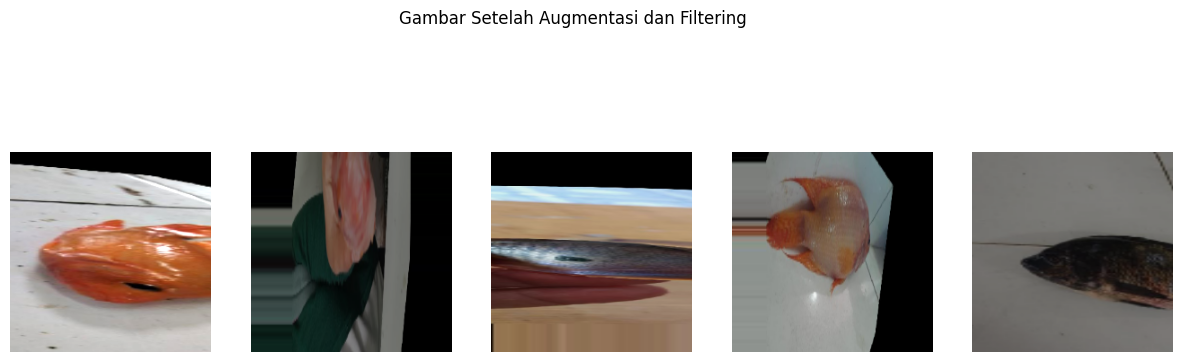

In [31]:
# Fungsi visualisasi
def visualize_augmented_images(generator, num_images=5):
    images, labels = next(generator)
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    
    plt.suptitle("Gambar Setelah Augmentasi dan Filtering")
    plt.show()

# Visualisasikan gambar
visualize_augmented_images(train_generator, num_images=5)

# Model

## ANN

In [32]:
# Model
model = Sequential([
    Input(shape=INPUT_SHAPE),
    Flatten(),

    Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),  

    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3), 

    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3), 

    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),  

    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3), 

    Dense(NUM_CLASSES, activation='softmax')
])


# Kompilasi model
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │   154,141,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,847,107 (590.69 MB)

 Trainable params: 154,843,139 (590.68 MB)

 Non-trainable params: 3,968 (15.50 KB)

# Tranfer Learning

## Prebuild model

### Build Base Model

In [33]:
# get base models
base_model = MobileNet(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet',
    classes=NUM_CLASSES,
)

# add to top layer

In [34]:
from tensorflow.keras import layers
# Adding custom layers after ResNet50
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)  

x = layers.Dropout(0.5)(x) 
x = layers.Dense(512, activation="relu")(x) 

x = layers.Dropout(0.5)(x) 
x = layers.Dense(256, activation="relu")(x) 

# Output layer
predictions = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,935,363 (18.83 MB)

 Trainable params: 4,913,475 (18.74 MB)

 Non-trainable params: 21,888 (85.50 KB)

### Build Base model

In [35]:
# from efficientnet.tfkeras import EfficientNetB1

# # get base models
# base_model = EfficientNetB1(
#     input_shape=INPUT_SHAPE,
#     include_top=False,
#     weights='noisy-student',
#     classes=NUM_CLASSES,
# )

### Add top network layer to models

In [36]:
# from tensorflow.keras import layers,Sequential
# from tensorflow.keras.models import Model

# #Adding custom layers
# x = base_model.output
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(1024, activation="relu")(x)

# predictions = layers.Dense(NUM_CLASSES, activation="softmax")(x)
# model = Model(inputs=base_model.input, outputs=predictions)

# # model.summary()

# # Compile the model
# print('Compiling Model.......')
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# Hyperparameter Tuning

In [37]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [38]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [39]:
# Kompilasi model
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Training model
history = model.fit(
    train_generator,
    epochs= 25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/25


c:\Users\M S I\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.4873 - loss: 1.1825 - val_accuracy: 0.9712 - val_loss: 0.1701 - learning_rate: 1.0000e-04
Epoch 2/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.9111 - loss: 0.2572 - val_accuracy: 0.9877 - val_loss: 0.0364 - learning_rate: 1.0000e-04
Epoch 3/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.9709 - loss: 0.0948 - val_accuracy: 0.9918 - val_loss: 0.0128 - learning_rate: 1.0000e-04
Epoch 4/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.9845 - loss: 0.0495 - val_accuracy: 1.0000 - val_loss: 0.0024 - learning_rate: 1.0000e-04
Epoch 5/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.9839 - loss: 0.0572 - val_accuracy: 1.0000 - val_loss: 0.0022 - learning_rate: 1.0000e-04
Epoch 6/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 314s 4s/step - accuracy: 0.9897 - loss: 0.0303 - val_accuracy: 0.9959 - val_loss: 0.0082 - learning_rate: 1.0000e-04
Epoch 7/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.9894 - loss: 0.0

In [41]:
# Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - accuracy: 1.0000 - loss: 7.7913e-04
Test Accuracy: 1.00


In [42]:
history.history['loss']

[0.8649128079414368,
 0.2015339881181717,
 0.08131956309080124,
 0.05340379476547241,
 0.044476982206106186,
 0.036481235176324844,
 0.036282189190387726,
 0.023696105927228928,
 0.022980013862252235,
 0.02894904837012291]

In [43]:
history.history['accuracy']

[0.6247702836990356,
 0.932010293006897,
 0.9735391139984131,
 0.9823594093322754,
 0.9871370792388916,
 0.9893421530723572,
 0.9893421530723572,
 0.9922822713851929,
 0.9911797046661377,
 0.9897096753120422]

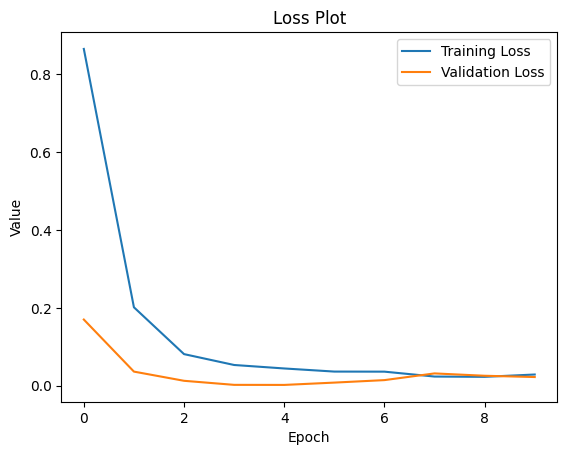

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

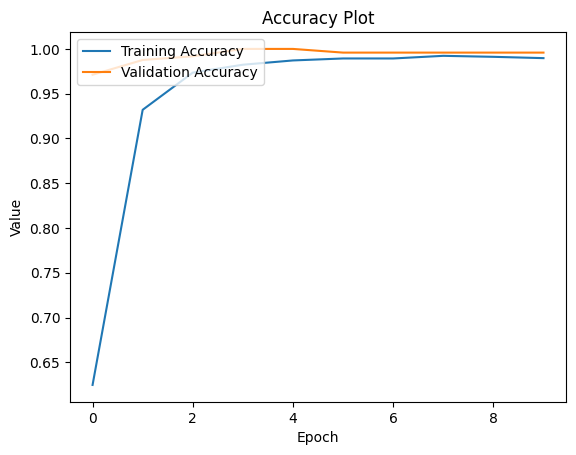

In [48]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

# Evaluate Models

In [56]:
loss, acc = model.evaluate(test_generator,steps=len(test_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_generator,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')   

Accuracy on training data: 1.0000 
Loss on training data: 0.0009 

Accuracy on test data: 1.0000 
Loss on test data: 0.0009 



## Pengujian Prediksi dengan Model Checkpoint


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


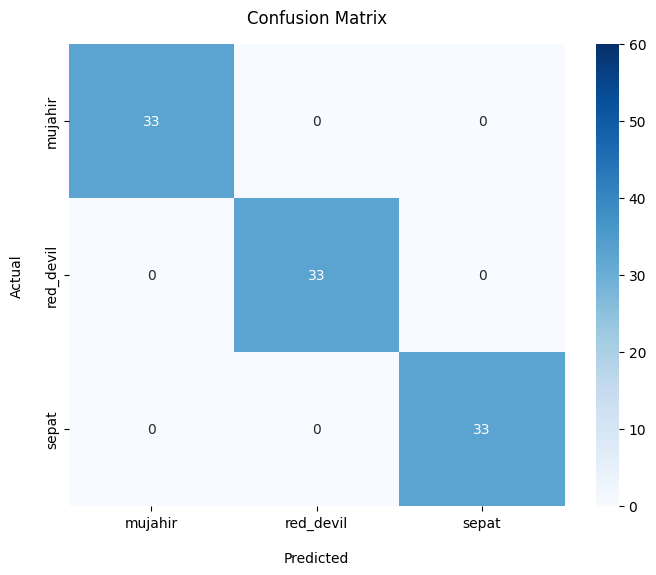

              precision    recall  f1-score   support

     mujahir       1.00      1.00      1.00        33
   red_devil       1.00      1.00      1.00        33
       sepat       1.00      1.00      1.00        33

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


checkpoint = load_model('../model/model_ANN_relu.keras')

predictions = checkpoint.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', vmin=0, vmax=60)
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('Actual', labelpad=15)
plt.title('Confusion Matrix', pad=15)
plt.show()

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


misclassified_indices = np.where(true_classes != predicted_classes)[0]

for idx in misclassified_indices:

    img_path = train_generator.filepaths[idx]
    true_label = class_labels[true_classes[idx]]
    pred_label = class_labels[predicted_classes[idx]]
    
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()

# Save Model

In [58]:
model.save('../model/model_ANN_relu.keras')

# Pengujuian Model

In [59]:
from tensorflow.keras.models import load_model


# Memuat model SavedModel
loaded_model = load_model('../model/model_ANN_relu.keras')

# Menampilkan ringkasan model untuk memastikan berhasil dimuat
# print(loaded_model.summary())



Predictions for class: mujahir
Processing dataset/test/mujahir\1_mp4-0012_jpg.rf.af408cddf66ccba558575e67d654671a.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
Processing dataset/test/mujahir\3_mp4-0001_jpg.rf.78c9387cea52f16b363b97e29b2224b4.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Processing dataset/test/mujahir\3_mp4-0007_jpg.rf.bad24d31e5fd7ac75000cc3bfa89e488.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Processing dataset/test/mujahir\3_mp4-0009_jpg.rf.7a6de95452636bd2a742b23d4faf81cd.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Processing dataset/test/mujahir\5_mp4-0015_jpg.rf.09ab1aaf6b49190b804d1e3d04cbcbc0.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Processing dataset/test/mujahir\6_mp4-0000_jpg.rf.977683a3c9107b8fb33a5b971cbebd3b.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Processing dataset/test/mujahir\6_mp4-0010_jpg.rf.0d2f29000f8d072d3f12176aa3aa6ef0.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processing dataset/test/mujahir\6_mp4-0013_jpg.rf.5e66c2d053fe7b1484bd

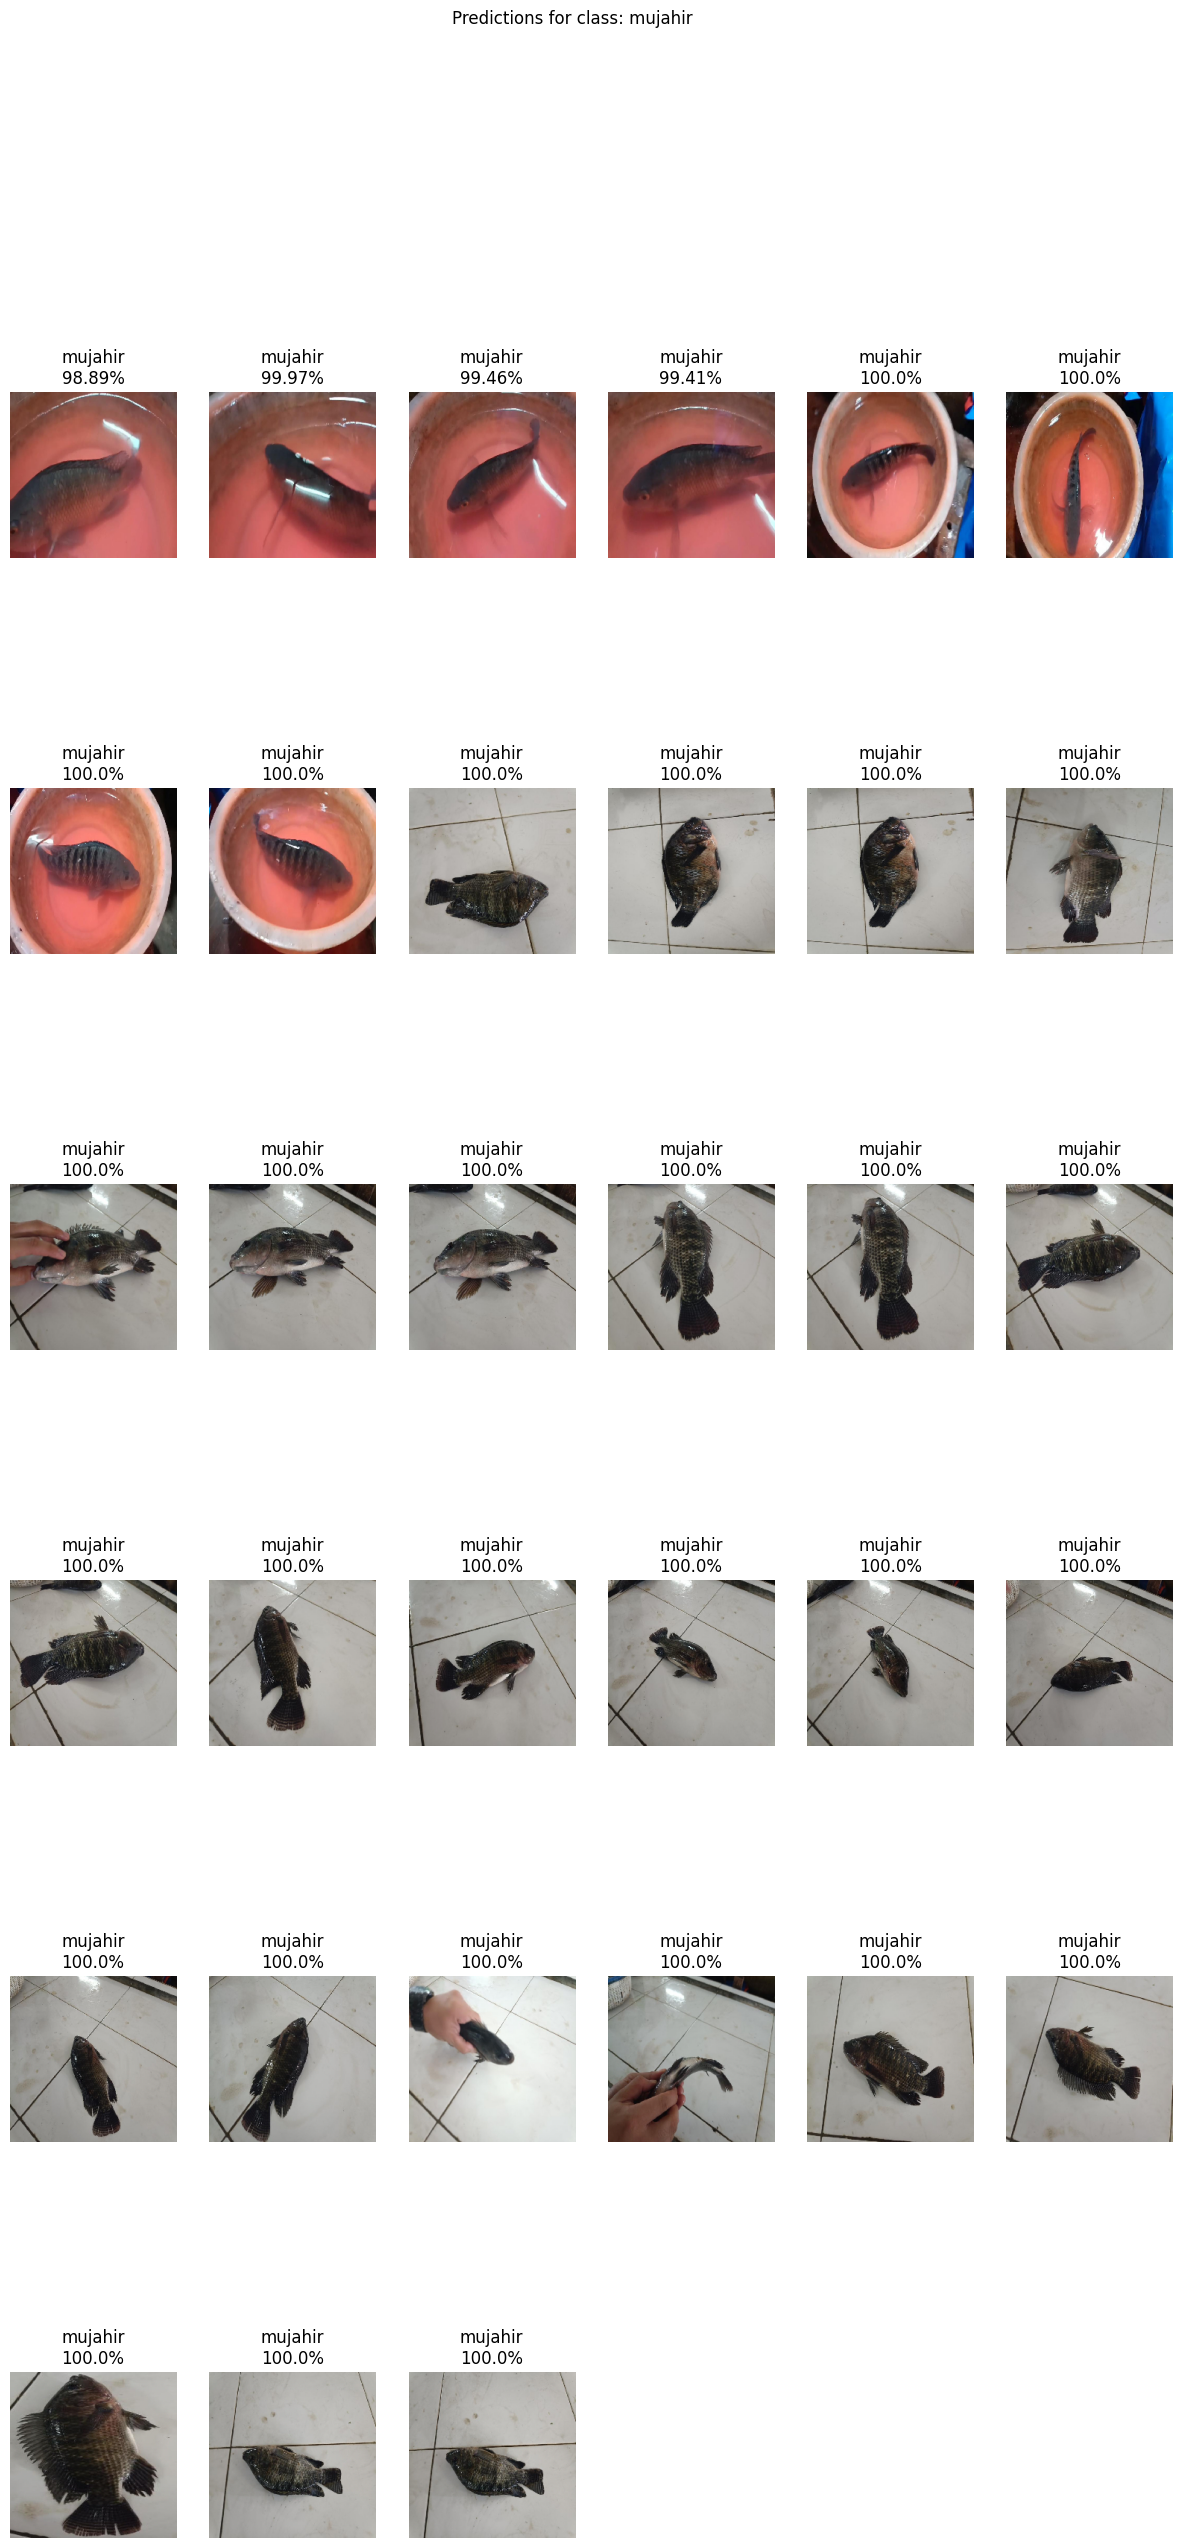


Predictions for class: red_devil
Processing dataset/test/red_devil\Red-Devil-101_png_jpg.rf.d9ed07b6e68c3e93176715b0010a3e33.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Processing dataset/test/red_devil\Red-Devil-104_png_jpg.rf.f98dbbec37a56d0a59d7e05f5344b89b.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Processing dataset/test/red_devil\Red-Devil-105_png_jpg.rf.b1efa865a6a211728f411c07d75584a5.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processing dataset/test/red_devil\Red-Devil-109_png_jpg.rf.7d9224c65e66461b159bda0982f45d7f.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processing dataset/test/red_devil\Red-Devil-122_png_jpg.rf.aa35b61ed0b16c3834001f5945a8fc38.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Processing dataset/test/red_devil\Red-Devil-132_png_jpg.rf.ae8fcd7bc96bbea6375168be5bcc857c.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Processing dataset/test/red_devil\Red-Devil-153-_jpg.rf.e300eec181f3255f1b7e705612f6c111.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processing

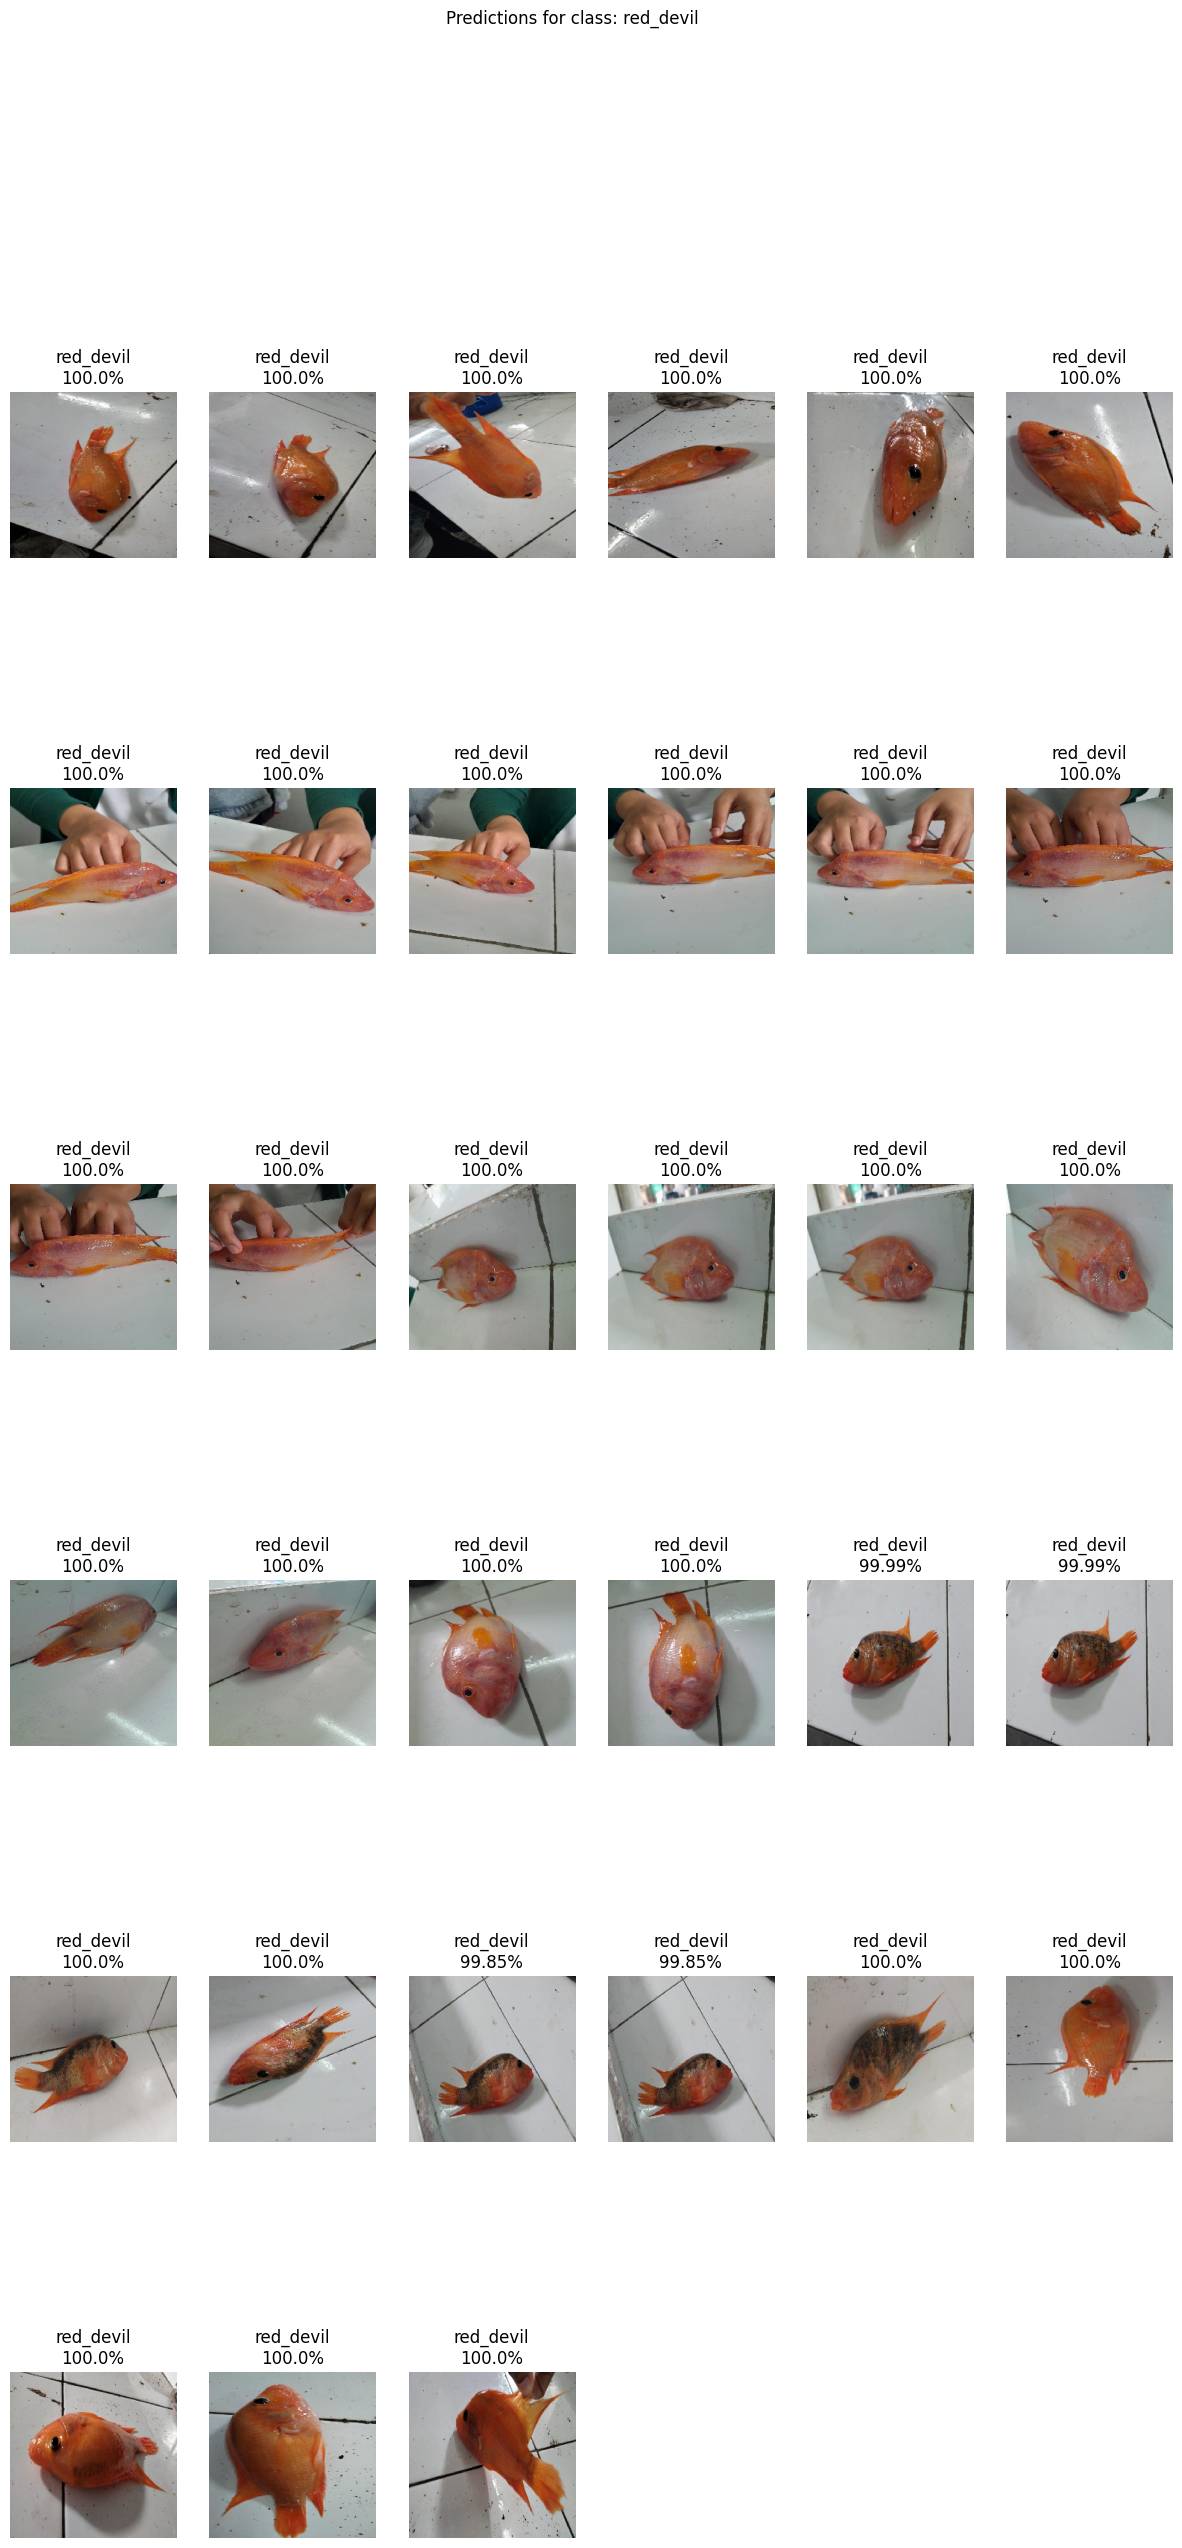


Predictions for class: sepat
Processing dataset/test/sepat\Sepat-104_png_jpg.rf.c8efe00703ee19d384763c8a05f1b4f6.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Processing dataset/test/sepat\Sepat-105_png_jpg.rf.e07125ea47295be33fcbe35134c37fc6.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Processing dataset/test/sepat\Sepat-115_png_jpg.rf.10ef20970ea1c9e1857d1192fa523831.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processing dataset/test/sepat\Sepat-117_png_jpg.rf.dfe4e7f8212150cc64d5ddef0e09aaf1.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Processing dataset/test/sepat\Sepat-15_png_jpg.rf.29fb2d9e7813596912e320f4e4017b8a.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processing dataset/test/sepat\Sepat-16_png_jpg.rf.eeed7dcbc9bb558bc6056c1e9964eb61.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Processing dataset/test/sepat\Sepat-176_jpg.rf.b6caed48284f4995afd08e63b1ee04ce.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Processing dataset/test/sepat\Sepat-184_jpg.rf.ccc8af4b661e42903d254dc517

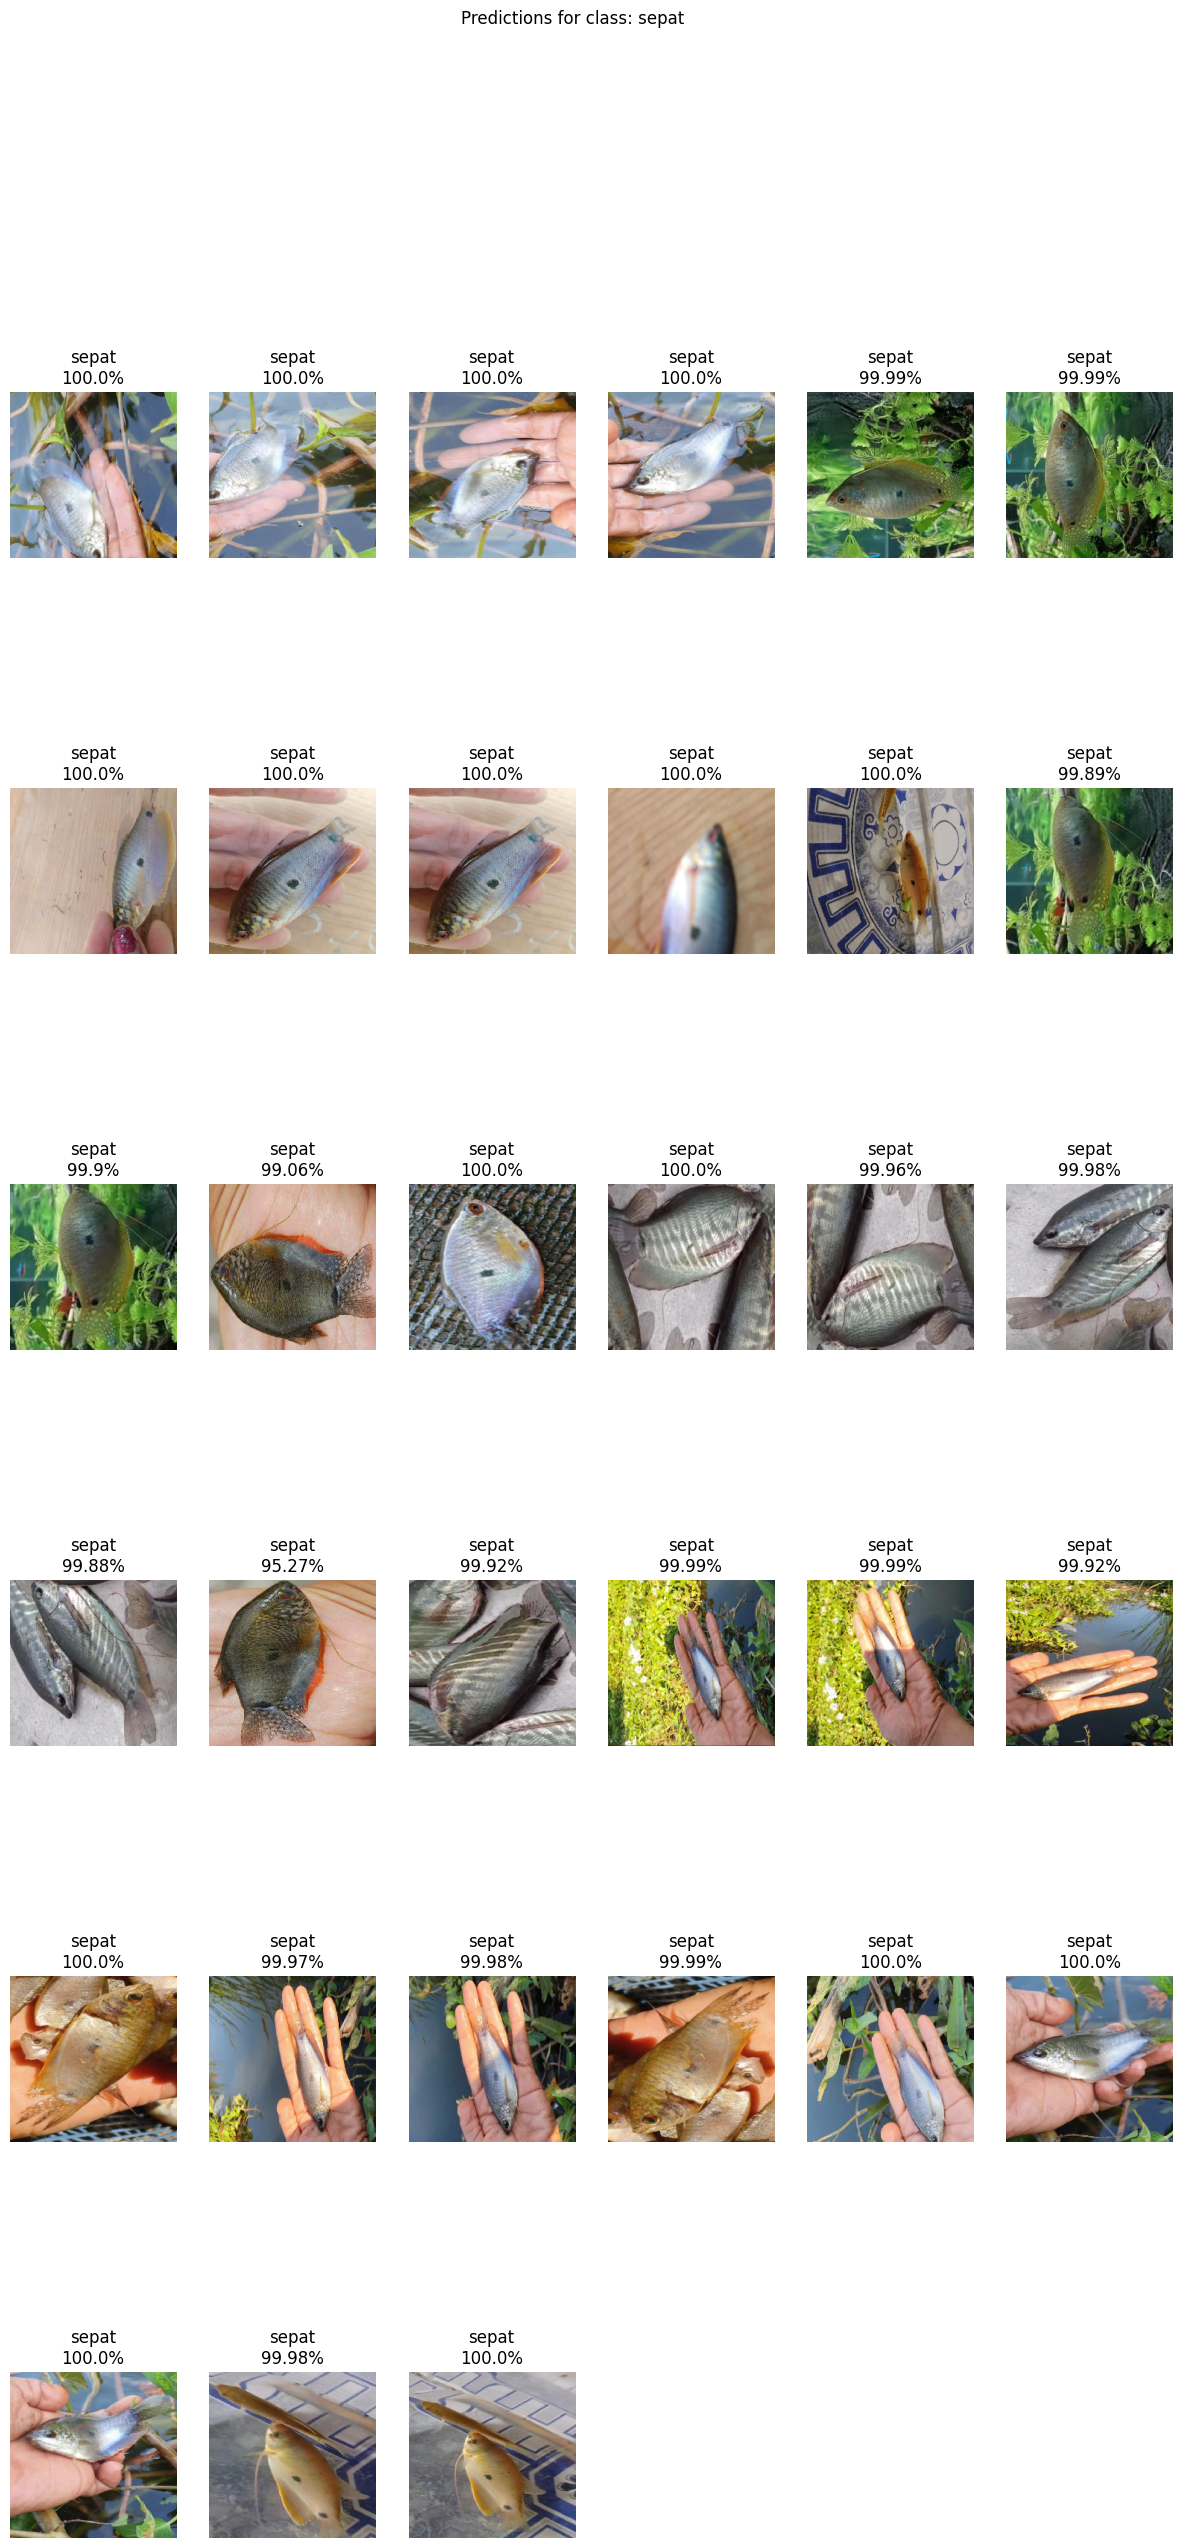

In [60]:
# Load model
model_path = '../model/model_ANN_relu.keras' 
loaded_model = load_model(model_path)

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=IMG_SIZE)  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  

    # Prediksi
    predictions = model.predict(img_array)
    predict_class = np.argmax(predictions[0]) 
    probability = np.max(predictions[0]) 

    # Map kelas ke label
    labels = ['mujahir', 'red_devil', 'sepat'] 
    label = labels[predict_class]

    return img, label, round(probability * 100, 2)

def predict_images_from_class(class_folder, model):
    images = []
    labels = []
    probabilities = []

    # Ambil semua gambar dari folder kelas tertentu
    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
            print(f"Processing {img_path}...")
            img, label, probability = predict_image(img_path, model)
            images.append(img)
            labels.append(label)
            probabilities.append(probability)

    return images, labels, probabilities

dataset_path = 'dataset/test/'

classes = ['mujahir', 'red_devil', 'sepat']

# Prediksi gambar dari setiap kelas
for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    print(f"\nPredictions for class: {class_name}")
    images, labels, probabilities = predict_images_from_class(class_folder, loaded_model)
    max_images_per_row = 6
    num_rows = (len(images) + max_images_per_row - 1) // max_images_per_row 

    plt.figure(figsize=(15, 5 * num_rows))
    for i in range(len(images)):
        plt.subplot(num_rows, max_images_per_row, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f"{labels[i]}\n{probabilities[i]}%")
    
    plt.suptitle(f"Predictions for class: {class_name}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step


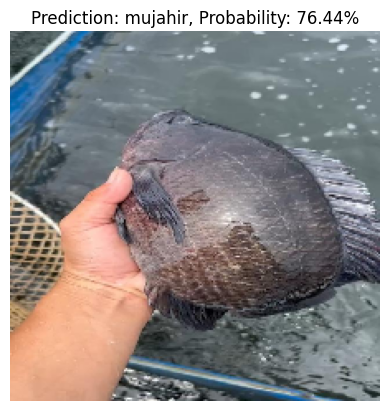

Label: mujahir
Probability: 76.44%


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE= (224, 224)

model_path = '../model/model_ANN_relu.keras' 
loaded_model = load_model(model_path)

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(IMG_SIZE))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  

    # Prediksi
    predictions = model.predict(img_array)
    predict_class = np.argmax(predictions[0]) 
    probability = np.max(predictions[0]) 

    # Map kelas ke label
    labels = ['mujahir', 'red_devil', 'sepat'] 
    label = labels[predict_class]

    # Tampilkan hasil
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {label}, Probability: {round(probability * 100, 2)}%")
    plt.show()

    print(f"Label: {label}")
    print(f"Probability: {round(probability * 100, 2)}%")

# Path ke gambar

# img_path = 'new_data/Ikan-Sepat.jpg'
# img_path = 'new_data/ikan-red-devil-3137882226 .jpg'
# img_path = 'new_data/ikan-mujair1.jpg'
# img_path = 'new_data/6n (238).jpg'
# img_path = 'new_data/Red-devil2.jpg'
# img_path = 'new_data/devil.jpg'


# Prediksi gambar
predict_image(img_path, loaded_model)


In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model


# Path ke model Anda
model_path = '../model/model_ANN_relu.keras'
loaded_model = load_model(model_path)

labels = ['mujahir', 'red_devil', 'sepat'] 

# Fungsi untuk melakukan prediksi
def predict_frame(frame, model):

    resized_frame = cv2.resize(frame, (224, 224)) 
    normalized_frame = resized_frame / 255.0  
    input_frame = np.expand_dims(normalized_frame, axis=0)  # Tambah dimensi batch

    # Prediksi menggunakan model
    predictions = model.predict(input_frame)
    predicted_label = labels[np.argmax(predictions)]
    confidence = np.max(predictions) * 100  # Confidence dalam persen
    return predicted_label, confidence

# Inisialisasi kamera
cap = cv2.VideoCapture(0) 

if not cap.isOpened():
    print("Kamera tidak dapat diakses!")
    exit()

print("Menyalakan kamera. Tekan 'q' untuk keluar.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Tidak dapat membaca frame dari kamera.")
        break

    # Lakukan prediksi pada frame saat ini
    predicted_label, confidence = predict_frame(frame, loaded_model)

    # Tampilkan prediksi di frame
    text = f"{predicted_label}: {confidence:.2f}%"
    cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Tampilkan frame
    cv2.imshow("Real-time Prediction", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Menyalakan kamera. Tekan 'q' untuk keluar.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━